## PREDICT PRISON POPULATION WITH EDUCATION AND POVERTY DATA

Equipe :
    * Jessica Vilar - 1613176
    * Fernando Tancini - 1711799
    * Andrea Mourelo - 1820000

In [1]:
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries and functions
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
# Set a seed value: 
seed_value= 12321  
# 1. Set PYTHONHASHSEED environment variable at a fixed value: 
import os
os.environ['PYTHONHASHSEED']=str(seed_value) 
# 2. Set python built-in pseudo-random generator at a fixed value:
import random
random.seed(seed_value) 
# 3. Set numpy pseudo-random generator at a fixed value:
np.random.seed(seed_value) 

## Preparaçao dos dados

In [3]:
# Dados incompletos coletados do site http://hdr.undp.org/en/content/developing-regions  (menu esquerda 'Download DB 2018')
filename = 'Dados/HDR_2018_all_indicators.xlsx'
file_with_sheets = pd.ExcelFile(filename)
first_data = pd.read_excel(file_with_sheets, 'Data')
sheet_9999 = pd.read_excel(file_with_sheets, '9999') # para verificar os significados da coluna 9999

# Dados coletados a partir de outra fonte para categorizar os países por região e tipo de renda
metadata_filename = 'Dados/HDR_2018_country_metadata.xlsx'
country_metadata = pd.read_excel(metadata_filename)

# Fazemos merge para poder categorizar os dados por região e tipo de renda
data = pd.merge(left=first_data, right=country_metadata, how='left', left_on='iso3', right_on='Code')

# Evitamos redundâncias
data.drop('Code', axis=1, inplace=True) # 1 is the axis number (0 for rows and 1 for columns) & inplace to not have to reassign a new df

# Mudando o nome de algumas colunas
data.rename(columns={'dimension':'category','iso3':'code','Long Name':'long_name','Income Group':'income_group','Region':'region'},inplace=True)

# Criamos uma linha por pais, indicador e ano
data_per_year = pd.melt(frame=data, id_vars=['category','indicator_id','indicator_name','code', 'country_name','long_name','income_group','region'], var_name = 'year')

data_per_year.drop('indicator_id', axis=1, inplace=True)
data_per_year.drop('long_name', axis=1, inplace=True)

# Depois desse comando, vamos ter um MultiIndex com uma linha por pais e ano e todos os indicadores em colunas
data_tidy = data_per_year.pivot_table(index=['code', 'country_name','income_group','region','year'],
                                     columns = 'indicator_name', values = 'value')

# Isso vai permitir voltar a um DataFrame normal
data_tidy.reset_index(inplace=True)

# Lidando com dados reais (Abordagem 1)#
Como os países não tiveram pesquisas nos mesmos anos, nossa fonte de dados agrupou alguns anos (ou um ano) na coluna 9999. 

Nessa primeira abordagem, iremos usar os dados da coluna 9999 de cada país e checar os resultados.

In [4]:
# Função para visualizar os agrupamentos do ano 9999
def get9999Meaning (categories):
    indicators = data[data.category.isin(categories)].indicator_name.unique()
    return sheet_9999[sheet_9999.indicator_name.isin(indicators)]

In [5]:
# Dados de pobreza
get9999Meaning(['Poverty'])

,indicator_id,indicator_name,9999
90,117806,MPI 2018: Contribution of Education,2006-2017
91,117906,MPI 2018: Contribution of Health,2006-2017
92,118006,MPI 2018: Contribution of standard of living,2006-2017
93,100906,MPI 2018: Year of MPI,2006-2017
94,38406,Multidimensional poverty index (MPI),2006-2017
103,38606,"Population in multidimensional poverty, headco...",2006-2017
104,102006,"Population in multidimensional poverty, headco...",2006-2017
105,183406,"Population in multidimensional poverty, headco...",2006-2017
106,38506,"Population in multidimensional poverty, intens...",2006-2017
107,101006,Population in severe multidimensional poverty (%),2006-2017


In [6]:
# Dados de Educação
get9999Meaning(['Education'])

,indicator_id,indicator_name,9999
14,103706,Education index,NaN
20,69706,Expected years of schooling (years),2017
21,123306,"Expected years of schooling, female (years)",2017
22,123406,"Expected years of schooling, male (years)",2017
34,149206,Government expenditure on education (% of GDP),2012-2017
37,133006,"Gross enrolment ratio, pre-primary (% of presc...",2012-2017
38,63206,"Gross enrolment ratio, primary (% of primary s...",2012-2017
39,63306,"Gross enrolment ratio, secondary (% of seconda...",2012-2017
40,63406,"Gross enrolment ratio, tertiary (% of tertiary...",2012-2017
75,101406,"Literacy rate, adult (% ages 15 and older)",2006-2016


In [7]:
# Dados de pobreza
sheet_9999[sheet_9999.indicator_name.isin(['Prison population (per 100,000 people)'])]

,indicator_id,indicator_name,9999
119,128306,"Prison population (per 100,000 people)",2004-2015


In [8]:
# Função para criar um df com dados de uma ou mais categorias

data = data[data.indicator_name != 'MPI 2018: Year of MPI'] # Jogamos fora essa categoria pois nao tem dado nenhum

def data_categorias(categorias):  # categorias sendo uma lista
    indicators = data[data.category.isin(categorias)].indicator_name.unique()
    other_columns = np.array(['country_name','income_group','region', 'year'])
    columns_to_return = np.concatenate((other_columns,indicators))
    return data_tidy[columns_to_return]

In [9]:
# Extraindo dados para regressao

# Dados pobreza
data_poverty_allyears = data_categorias(['Poverty'])
data_poverty = data_poverty_allyears[data_poverty_allyears.year == 9999]

# Dados educacao
data_education_allyears = data_categorias(['Education'])
data_education = data_education_allyears[data_education_allyears.year == 9999]

# Dados prisao
data_prison_allyears = data_tidy[['country_name','income_group','region','year','Prison population (per 100,000 people)']]
data_prison = data_prison_allyears[data_prison_allyears.year == 9999] # Dados estao no ano 9999

# Modificando indexes poverty

data_poverty.drop(['year','income_group','region'],axis=1, inplace=True)
data_poverty.reset_index(drop=True,inplace=True)

data_education.drop(['year','income_group','region'],axis=1, inplace=True)
data_education.reset_index(drop=True,inplace=True)

data_prison.drop(['year'],axis=1, inplace=True)
data_prison.reset_index(drop=True,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
data_between = pd.merge(left=data_prison, right=data_education, how='inner', left_on='country_name', right_on='country_name')
data = pd.merge(left=data_between, right=data_poverty, how='inner', left_on='country_name', right_on='country_name')
data

indicator_name,country_name,income_group,region,"Prison population (per 100,000 people)",Education index,Expected years of schooling (years),"Expected years of schooling, female (years)","Expected years of schooling, male (years)",Government expenditure on education (% of GDP),"Gross enrolment ratio, pre-primary (% of preschool-age children)",...,Multidimensional poverty index (MPI),"Population in multidimensional poverty, headcount (%)","Population in multidimensional poverty, headcount (thousands) (for the year of the survey)","Population in multidimensional poverty, headcount (thousands) (projection for 2016)","Population in multidimensional poverty, intensity of deprivation (%)",Population in severe multidimensional poverty (%),"Population living below income poverty line, national poverty line (%)","Population living below income poverty line, PPP $1.90 a day (%)",Population vulnerable to multidimensional poverty (%),Working poor at PPP$3.10 a day (% of total employment)
0,Afghanistan,Low income,South Asia,74.0,0.415,10.4,8.0,12.7,3.2,NaN,...,0.273,56.1,19442.0,19442.0,48.7,25.1,35.8,NaN,18.0,98.2
1,Angola,Lower middle income,Sub-Saharan Africa,106.0,0.498,11.8,11.0,12.7,NaN,NaN,...,0.283,51.2,14743.0,14743.0,55.3,32.5,36.6,30.1,15.5,59.0
2,Albania,Upper middle income,Europe & Central Asia,189.0,0.745,14.8,15.0,14.4,3.5,88.0,...,0.008,2.0,60.0,60.0,37.8,0.2,14.3,1.1,7.3,1.5
3,Andorra,High income,Europe & Central Asia,72.0,0.714,13.5,NaN,NaN,3.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,High income,Middle East & North Africa,229.0,0.738,13.6,14.3,13.4,NaN,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
5,Argentina,High income,Latin America & Caribbean,160.0,0.816,17.4,18.7,16.2,5.9,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8
6,Armenia,Upper middle income,Europe & Central Asia,130.0,0.749,13.0,13.4,12.6,2.8,52.0,...,0.001,0.2,5.0,5.0,36.2,0.0,29.4,1.8,2.7,10.1
7,Antigua and Barbuda,High income,Latin America & Caribbean,373.0,0.676,13.2,13.9,12.6,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Australia,High income,East Asia & Pacific,151.0,0.929,22.9,23.3,22.5,5.2,169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Austria,High income,Europe & Central Asia,95.0,0.852,16.1,16.4,15.8,5.4,104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Modificando nomes das colunas para que estejam mais compactadas

# Jogamos fora as partes de (% of ...)
new_cols = []
for element in data.columns:
    if '(%' in element : 
        element = element.split(' (%')[0]
    if '(years)' in element : 
        element = element.split(' (years)')[0]
    new_cols.append(element)
data.columns = new_cols

# Modificando alguns na mão
data.rename(columns={'Prison population (per 100,000 people)':'Prison population'},inplace=True)

data

,country_name,income_group,region,Prison population,Education index,Expected years of schooling,"Expected years of schooling, female","Expected years of schooling, male",Government expenditure on education,"Gross enrolment ratio, pre-primary",...,Multidimensional poverty index (MPI),"Population in multidimensional poverty, headcount","Population in multidimensional poverty, headcount (thousands) (for the year of the survey)","Population in multidimensional poverty, headcount (thousands) (projection for 2016)","Population in multidimensional poverty, intensity of deprivation",Population in severe multidimensional poverty,"Population living below income poverty line, national poverty line","Population living below income poverty line, PPP $1.90 a day",Population vulnerable to multidimensional poverty,Working poor at PPP$3.10 a day
0,Afghanistan,Low income,South Asia,74.0,0.415,10.4,8.0,12.7,3.2,NaN,...,0.273,56.1,19442.0,19442.0,48.7,25.1,35.8,NaN,18.0,98.2
1,Angola,Lower middle income,Sub-Saharan Africa,106.0,0.498,11.8,11.0,12.7,NaN,NaN,...,0.283,51.2,14743.0,14743.0,55.3,32.5,36.6,30.1,15.5,59.0
2,Albania,Upper middle income,Europe & Central Asia,189.0,0.745,14.8,15.0,14.4,3.5,88.0,...,0.008,2.0,60.0,60.0,37.8,0.2,14.3,1.1,7.3,1.5
3,Andorra,High income,Europe & Central Asia,72.0,0.714,13.5,NaN,NaN,3.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,High income,Middle East & North Africa,229.0,0.738,13.6,14.3,13.4,NaN,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
5,Argentina,High income,Latin America & Caribbean,160.0,0.816,17.4,18.7,16.2,5.9,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8
6,Armenia,Upper middle income,Europe & Central Asia,130.0,0.749,13.0,13.4,12.6,2.8,52.0,...,0.001,0.2,5.0,5.0,36.2,0.0,29.4,1.8,2.7,10.1
7,Antigua and Barbuda,High income,Latin America & Caribbean,373.0,0.676,13.2,13.9,12.6,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Australia,High income,East Asia & Pacific,151.0,0.929,22.9,23.3,22.5,5.2,169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Austria,High income,Europe & Central Asia,95.0,0.852,16.1,16.4,15.8,5.4,104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(data_education.shape, data_poverty.shape, data.shape)
# Temos bem 195 linhas (paises) e 40 colunas (2 de descripcao do pais + 1 de prison + 24 de education + 13 de poverty)
# O indice nao conta na contagem de colunas


(195, 25) (195, 14) (195, 41)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 41 columns):
country_name                                                                                  195 non-null object
income_group                                                                                  195 non-null object
region                                                                                        195 non-null object
Prison population                                                                             189 non-null float64
Education index                                                                               189 non-null float64
Expected years of schooling                                                                   192 non-null float64
Expected years of schooling, female                                                           181 non-null float64
Expected years of schooling, male                                                            

Todas as colunas estao em float, OK!

In [14]:
data.describe()

,Prison population,Education index,Expected years of schooling,"Expected years of schooling, female","Expected years of schooling, male",Government expenditure on education,"Gross enrolment ratio, pre-primary","Gross enrolment ratio, primary","Gross enrolment ratio, secondary","Gross enrolment ratio, tertiary",...,Multidimensional poverty index (MPI),"Population in multidimensional poverty, headcount","Population in multidimensional poverty, headcount (thousands) (for the year of the survey)","Population in multidimensional poverty, headcount (thousands) (projection for 2016)","Population in multidimensional poverty, intensity of deprivation",Population in severe multidimensional poverty,"Population living below income poverty line, national poverty line","Population living below income poverty line, PPP $1.90 a day",Population vulnerable to multidimensional poverty,Working poor at PPP$3.10 a day
count,189.000000,189.000000,192.000000,181.000000,181.000000,140.000000,166.000000,178.000000,167.000000,151.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,95.000000,88.000000,105.000000,134.000000
mean,165.333333,0.651466,13.243750,13.439227,13.259116,4.670000,64.843373,102.589888,85.077844,40.364238,...,0.159248,30.576190,12355.409524,12698.733333,45.830476,16.180000,33.651579,22.055682,13.652381,28.513433
std,128.892913,0.173108,2.926618,3.361391,2.663349,1.706176,35.447950,12.162985,28.563182,28.168655,...,0.161083,27.699592,38854.233473,38953.619732,7.484293,19.808193,18.117987,22.662425,7.956856,29.428805
min,16.000000,0.214000,4.900000,3.800000,5.800000,1.400000,1.000000,54.000000,10.000000,2.000000,...,0.001000,0.200000,2.000000,2.000000,34.200000,0.000000,2.700000,0.000000,0.400000,0.000000
25%,73.000000,0.514000,11.400000,11.200000,11.800000,3.475000,34.500000,98.000000,66.000000,13.500000,...,0.017000,4.400000,264.000000,297.000000,39.500000,0.600000,20.300000,2.500000,6.300000,2.725000
50%,129.000000,0.680000,13.150000,13.700000,13.200000,4.600000,70.500000,102.000000,93.000000,37.000000,...,0.121000,27.500000,2598.000000,2737.000000,45.200000,8.600000,30.500000,14.850000,13.500000,15.050000
75%,216.000000,0.790000,15.125000,15.800000,15.000000,5.625000,92.000000,108.000000,103.000000,63.000000,...,0.262000,52.000000,9253.000000,10217.000000,51.600000,25.100000,46.600000,38.100000,19.400000,52.475000
max,799.000000,0.940000,22.900000,23.300000,22.500000,12.500000,176.000000,144.000000,164.000000,122.000000,...,0.591000,91.900000,364225.000000,364225.000000,65.300000,74.900000,72.300000,77.600000,34.700000,98.200000


## Analise (1 variavel)

Vamos plotar alguns dados para ver se parece existir correlaçao

## Education

[Text(0, 0.5, 'Prison population'),
 Text(0.5, 0, 'Survival rate to the last grade\n of lower secondary general education')]

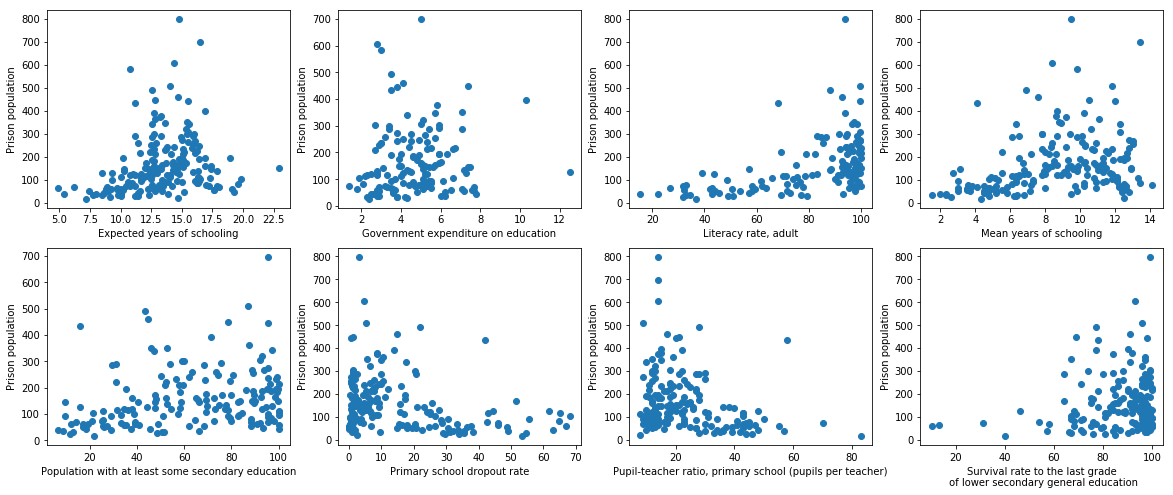

In [15]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
x1 = data['Expected years of schooling']
x2 = data['Government expenditure on education']
x3 = data['Literacy rate, adult']
x4 = data['Mean years of schooling']
x5 = data['Population with at least some secondary education']
x6 = data['Primary school dropout rate']
x7 = data['Pupil-teacher ratio, primary school (pupils per teacher)']
x8 = data['Survival rate to the last grade of lower secondary general education']
y = data['Prison population']

ax1.scatter(x1, y)
ax1.set(xlabel='Expected years of schooling', ylabel='Prison population')
ax2.scatter(x2, y)
ax2.set(xlabel='Government expenditure on education', ylabel='Prison population')
ax3.scatter(x3, y)
ax3.set(xlabel='Literacy rate, adult', ylabel='Prison population')
ax4.scatter(x4, y)
ax4.set(xlabel='Mean years of schooling', ylabel='Prison population')
ax5.scatter(x5, y)
ax5.set(xlabel='Population with at least some secondary education', ylabel='Prison population')
ax6.scatter(x6, y)
ax6.set(xlabel='Primary school dropout rate', ylabel='Prison population')
ax7.scatter(x7, y)
ax7.set(xlabel='Pupil-teacher ratio, primary school (pupils per teacher)', ylabel='Prison population')
ax8.scatter(x8, y)
ax8.set(xlabel='Survival rate to the last grade\n of lower secondary general education', ylabel='Prison population')


Poderia ter uma regressao em :
* Literacy rate, adult 
* Mean years of schooling


(muito puxado mas tudo bem kkk)


### Literacy rate adult x Prison population

Coefficients:      [2.6794235]
Intercept:         -50.23173055279028
Mean squared error: 4081.47
Variance score:     0.34


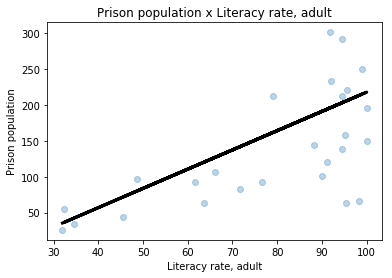

In [16]:
data_literacy = data[['Prison population', 'Literacy rate, adult']].dropna()

dfTrain, dfTest = train_test_split(data_literacy, test_size=0.2,  random_state = seed_value)
X_train = dfTrain['Literacy rate, adult'][:, np.newaxis]
y_train = dfTrain['Prison population']

X_test = dfTest['Literacy rate, adult'][:, np.newaxis]
y_test = dfTest['Prison population']

# Create linear regression object
regr = sk.linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test, alpha=0.3)
plt.plot(X_test, y_pred, color='k', linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.xlabel('Literacy rate, adult')
plt.ylabel('Prison population')
plt.title('Prison population x Literacy rate, adult')

plt.show()

=> Bastante ruim

### Mean years of schooling x Prison population

Coefficients:      [12.77412589]
Intercept:         62.225821081593935
Mean squared error: 10273.98
Variance score:     -0.01


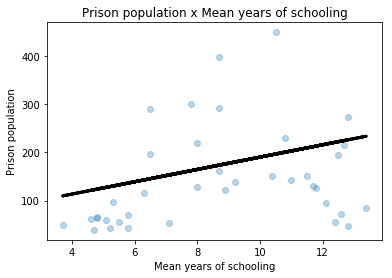

In [17]:
data_schooling = data[['Prison population', 'Mean years of schooling']].dropna()

dfTrain, dfTest = train_test_split(data_schooling, test_size=0.2,  random_state = seed_value)
X_train = dfTrain['Mean years of schooling'][:, np.newaxis]
y_train = dfTrain['Prison population']

X_test = dfTest['Mean years of schooling'][:, np.newaxis]
y_test = dfTest['Prison population']

# Create linear regression object
regr = sk.linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test, alpha=0.3)
plt.plot(X_test, y_pred, color='k', linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.xlabel('Mean years of schooling')
plt.ylabel('Prison population')
plt.title('Prison population x Mean years of schooling')

plt.show()

=> Ainda pior...

## Poverty

[Text(0, 0.5, 'Prison population'),
 Text(0.5, 0, 'Working poor at PPP$3.10 a day')]

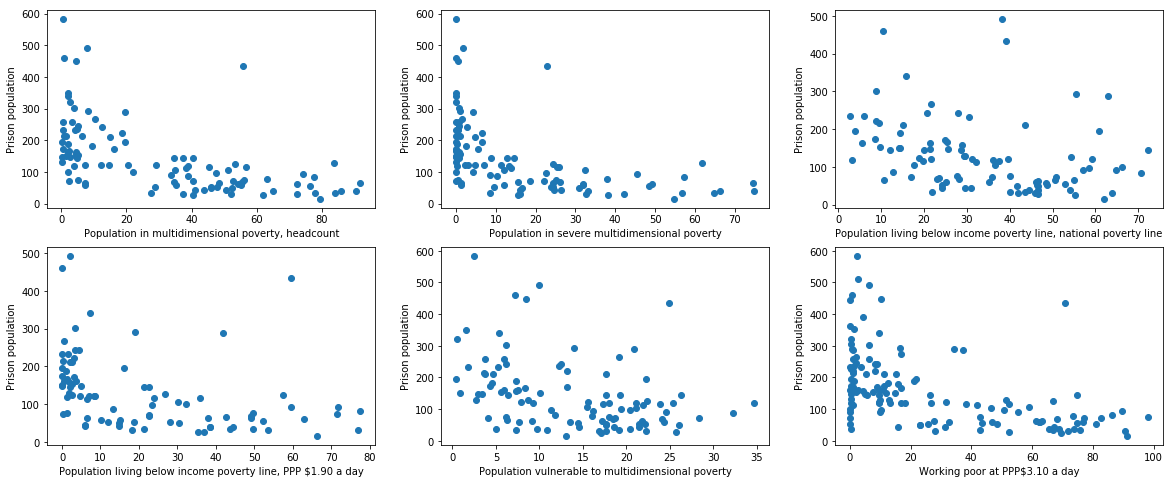

In [18]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
x1 = data['Population in multidimensional poverty, headcount']
x2 = data['Population in severe multidimensional poverty']
x3 = data['Population living below income poverty line, national poverty line']
x4 = data['Population living below income poverty line, PPP $1.90 a day']
x5 = data['Population vulnerable to multidimensional poverty']
x6 = data['Working poor at PPP$3.10 a day']
y = data['Prison population']

ax1.scatter(x1, y)
ax1.set(xlabel='Population in multidimensional poverty, headcount', ylabel='Prison population')
ax2.scatter(x2, y)
ax2.set(xlabel='Population in severe multidimensional poverty', ylabel='Prison population')
ax3.scatter(x3, y)
ax3.set(xlabel='Population living below income poverty line, national poverty line', ylabel='Prison population')
ax4.scatter(x4, y)
ax4.set(xlabel='Population living below income poverty line, PPP $1.90 a day', ylabel='Prison population')
ax5.scatter(x5, y)
ax5.set(xlabel='Population vulnerable to multidimensional poverty', ylabel='Prison population')
ax6.scatter(x6, y)
ax6.set(xlabel='Working poor at PPP$3.10 a day', ylabel='Prison population')


Poderia ter uma regressao em :
* Population living below income poverty line, PPP $1.90 a day

(nao muito, mas...por tentar...)

Coefficients:      [-1.48144666]
Intercept:         162.08417456674633
Mean squared error: 8926.92
Variance score:     0.24


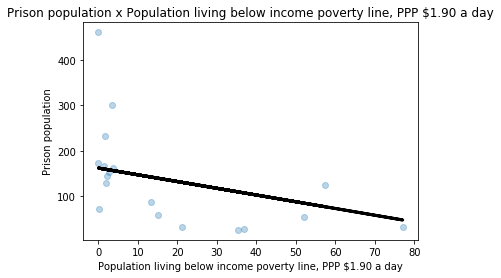

In [19]:
data_povertyline = data[['Prison population', 'Population living below income poverty line, PPP $1.90 a day']].dropna()

dfTrain, dfTest = train_test_split(data_povertyline, test_size=0.2, random_state = seed_value)
X_train = dfTrain['Population living below income poverty line, PPP $1.90 a day'][:, np.newaxis]
y_train = dfTrain['Prison population']

X_test = dfTest['Population living below income poverty line, PPP $1.90 a day'][:, np.newaxis]
y_test = dfTest['Prison population']

# Create linear regression object
regr = sk.linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test, alpha=0.3)
plt.plot(X_test, y_pred, color='k', linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.xlabel('Population living below income poverty line, PPP $1.90 a day')
plt.ylabel('Prison population')
plt.title('Prison population x Population living below income poverty line, PPP $1.90 a day')

plt.show()

=> Ruim tb...

## Modelo 1
### Features 'Education Index' e 'Multidimensional poverty index (MPI)'

In [20]:
# Dados que usaremos
columns = ['Prison population', 'Education index', 'Multidimensional poverty index (MPI)']
prison = [columns[0]]
predictors = columns[1:]
data_model1 = data[['country_name', 'income_group'] + columns]
data_model1 = data_model1.dropna()  # Da # 102 linhas somente
data_model1

,country_name,income_group,Prison population,Education index,Multidimensional poverty index (MPI)
0,Afghanistan,Low income,74.0,0.415,0.273
1,Angola,Lower middle income,106.0,0.498,0.283
2,Albania,Upper middle income,189.0,0.745,0.008
6,Armenia,Upper middle income,130.0,0.749,0.001
10,Azerbaijan,Upper middle income,236.0,0.709,0.019
11,Burundi,Low income,93.0,0.424,0.404
13,Benin,Low income,77.0,0.471,0.346
14,Burkina Faso,Low income,34.0,0.286,0.520
15,Bangladesh,Lower middle income,43.0,0.508,0.194
19,Bosnia and Herzegovina,Upper middle income,73.0,0.718,0.008


In [21]:
# Modelo

# Separacao em grupos de teste e de treino
dfTrain, dfTest = train_test_split(data_model1, test_size=0.1, random_state = seed_value)

X_train = np.array(dfTrain[predictors])
y_train = np.array(dfTrain[prison])

X_test = np.array(dfTest[predictors])
y_test = np.array(dfTest[prison])

# Create linear regression object
regr = sk.linear_model.LinearRegression(normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Dados preditos
df_predicted = pd.DataFrame(data = y_test)
df_predicted['pred'] = y_pred
df_predicted.columns = ['test','pred']
print(df_predicted)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean Absolute Error: %.2f'% mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.2f'% mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)) + ' # Mean of Population Prison is 165.33')
print('Root Mean Squared Error in Percentage: %.2f' % (100*np.sqrt(mean_squared_error(y_test, y_pred))/165.33))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.

# considering only the mean values of y_train
print('Variance score (baseline): %.2f' % r2_score(y_test, [np.mean(y_train) for i in range(len(y_test))]))


     test        pred
0    53.0  154.331169
1   154.0  195.791986
2   150.0  214.978459
3   106.0  104.695057
4    39.0    2.117652
5    58.0   79.037920
6    62.0   76.496037
7    55.0   48.572759
8   119.0  200.100588
9   289.0  160.659397
10   31.0  125.270704
Coefficients:      [[ 197.67162564 -250.17095212]]
Intercept:         [77.05296727]
Mean Absolute Error: 53.81
Mean Squared Error: 4566.22
Root Mean Squared Error: 67.57 # Mean of Population Prison is 165.33
Root Mean Squared Error in Percentage: 40.87
Variance score:     0.13
Variance score (baseline): -0.45


Variance score muito perto de 0 => ruim, né ?

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


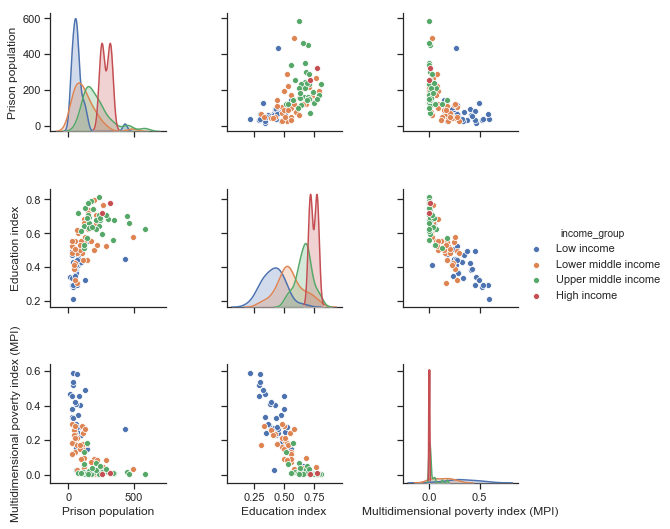

In [22]:
sns.set(style="ticks")
sns.pairplot(data_model1, hue='income_group')

#### Parece que nao tem correlaçao entre esses dois indicadores e o indicador de 'Prison population'

## Modelo 2
### Features 'Education Index', 'Multidimensional poverty index (MPI)' e 'Literacy rate, adult'

In [23]:
# Dados que usaremos
columns = ['Prison population', 'Education index', 'Multidimensional poverty index (MPI)', 'Literacy rate, adult']
prison = [columns[0]]
predictors = columns[1:]
data_model2 = data[['country_name', 'income_group'] + columns]
data_model2 = data_model2.dropna()  # Da # 102 linhas somente
data_model2

,country_name,income_group,Prison population,Education index,Multidimensional poverty index (MPI),"Literacy rate, adult"
0,Afghanistan,Low income,74.0,0.415,0.273,31.7
1,Angola,Lower middle income,106.0,0.498,0.283,66.0
2,Albania,Upper middle income,189.0,0.745,0.008,97.2
6,Armenia,Upper middle income,130.0,0.749,0.001,99.7
10,Azerbaijan,Upper middle income,236.0,0.709,0.019,99.8
11,Burundi,Low income,93.0,0.424,0.404,61.6
13,Benin,Low income,77.0,0.471,0.346,32.9
14,Burkina Faso,Low income,34.0,0.286,0.520,34.6
15,Bangladesh,Lower middle income,43.0,0.508,0.194,72.8
19,Bosnia and Herzegovina,Upper middle income,73.0,0.718,0.008,97.0


In [24]:
# Modelo

# Separacao em grupos de teste e de treino
dfTrain, dfTest = train_test_split(data_model2, test_size=0.1, random_state = seed_value)

X_train = np.array(dfTrain[predictors])
y_train = np.array(dfTrain[prison])

X_test = np.array(dfTest[predictors])
y_test = np.array(dfTest[prison])

# Create linear regression object
regr = sk.linear_model.LinearRegression(normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Dados preditos
df_predicted = pd.DataFrame(data = y_test)
df_predicted['pred'] = y_pred
df_predicted.columns = ['test','pred']
print(df_predicted)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean Absolute Error: %.2f'% mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.2f'% mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)) + ' # Mean of Population Prison is 165.33')
print('Root Mean Squared Error in Percentage: %.2f' % (100*np.sqrt(mean_squared_error(y_test, y_pred))/165.33))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.

# considering only the mean values of y_train
print('Variance score (baseline): %.2f' % r2_score(y_test, [np.mean(y_train) for i in range(len(y_test))]))


    test        pred
0   44.0   86.847497
1  174.0  199.986804
2   73.0  201.296030
3   39.0   -5.723068
4  148.0  201.624760
5   52.0   87.904078
6   31.0  105.400307
7  123.0  121.378773
8   34.0   17.111924
Coefficients:      [[ -66.86869163 -232.38319635    1.50787154]]
Intercept:         [104.90327716]
Mean Absolute Error: 47.14
Mean Squared Error: 3439.91
Root Mean Squared Error: 58.65 # Mean of Population Prison is 165.33
Root Mean Squared Error in Percentage: 35.47
Variance score:     -0.31
Variance score (baseline): -1.43


=> Parece que o modelo melhora (variance score aumentou), mesmo que o fator de 'Literacy rate, adult' nao tenha um peso (coeficiente) muito elevado

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


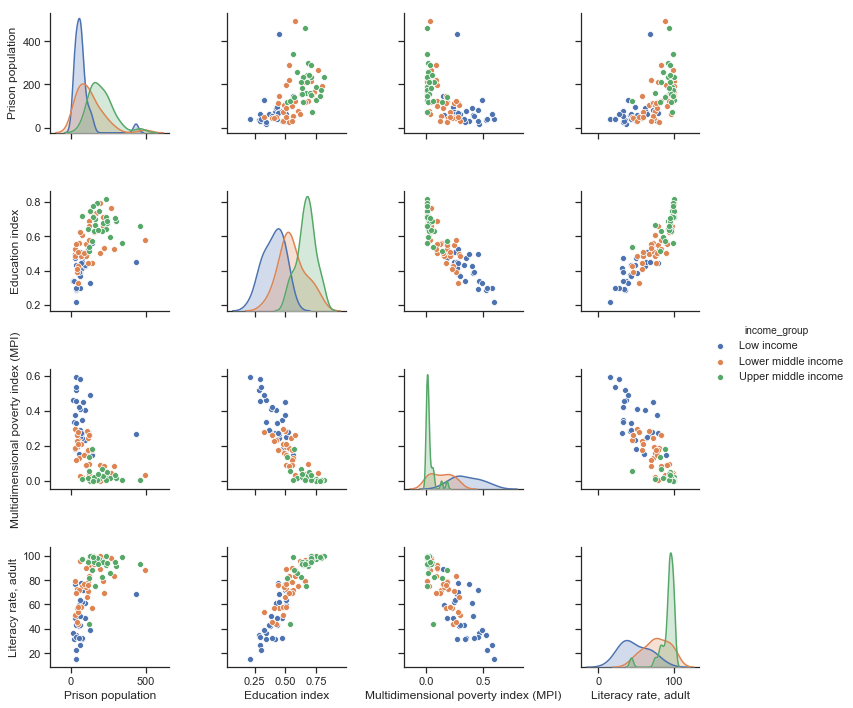

In [25]:
sns.set(style="ticks")
sns.pairplot(data_model2, hue='income_group')

## Modelo 3
### Features 'Education Index', 'Multidimensional poverty index (MPI)', 'Literacy rate, adult' e 'Population living below income poverty line, PPP $1.90 a day'

In [26]:
# Dados que usaremos
columns = ['Prison population', 'Education index', 'Multidimensional poverty index (MPI)',
           'Literacy rate, adult', 'Population living below income poverty line, PPP $1.90 a day']
prison = [columns[0]]
predictors = columns[1:]
data_model3 = data[['country_name', 'income_group'] + columns]
data_model3 = data_model3.dropna()  # Da # 102 linhas somente

In [27]:
# Modelo

# Separacao em grupos de teste e de treino
dfTrain, dfTest = train_test_split(data_model3, test_size=0.1, random_state = seed_value)

X_train = np.array(dfTrain[predictors])
y_train = np.array(dfTrain[prison])

X_test = np.array(dfTest[predictors])
y_test = np.array(dfTest[prison])

# Create linear regression object
regr = sk.linear_model.LinearRegression(normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Dados preditos
df_predicted = pd.DataFrame(data = y_test)
df_predicted['pred'] = y_pred
df_predicted.columns = ['test','pred']
print(df_predicted)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean Absolute Error: %.2f'% mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.2f'% mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)) + ' # Mean of Population Prison is 165.33')
print('Root Mean Squared Error in Percentage: %.2f' % (100*np.sqrt(mean_squared_error(y_test, y_pred))/165.33))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.

# considering only the mean values of y_train
print('Variance score (baseline): %.2f' % r2_score(y_test, [np.mean(y_train) for i in range(len(y_test))]))


    test        pred
0  145.0  114.353278
1  162.0  183.937308
2  266.0  178.636913
3  301.0  180.255173
4  130.0  190.885268
5  115.0  109.902465
6  162.0  150.919185
7   61.0   63.450374
Coefficients:      [[-1.33644045e+02 -1.72059132e+02  2.04187457e+00 -8.36167267e-02]]
Intercept:         [87.73233221]
Mean Absolute Error: 42.53
Mean Squared Error: 3436.73
Root Mean Squared Error: 58.62 # Mean of Population Prison is 165.33
Root Mean Squared Error in Percentage: 35.46
Variance score:     0.37
Variance score (baseline): -0.30


=> Aumentando o numero de features, diminuiu muito a qualidade do modelo

Vamos trocar os indicadores para ver se obtemos um melhor modelo

## Modelo 4
### Features 'Mean years of schooling', 'Primary school dropout rate' e 'Population in severe multidimensional poverty'

In [28]:
# Dados que usaremos
columns = ['Prison population', 'Mean years of schooling', 'Primary school dropout rate',
           'Population in severe multidimensional poverty']
prison = [columns[0]]
predictors = columns[1:]
data_model4 = data[['country_name', 'income_group'] + columns]
data_model4 = data_model4.dropna()  # Da # 102 linhas somente


# Modelo

# Separacao em grupos de teste e de treino
dfTrain, dfTest = train_test_split(data_model4, test_size=0.1, random_state = seed_value)

X_train = np.array(dfTrain[predictors])
y_train = np.array(dfTrain[prison])

X_test = np.array(dfTest[predictors])
y_test = np.array(dfTest[prison])

# Create linear regression object
regr = sk.linear_model.LinearRegression(normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Dados preditos
df_predicted = pd.DataFrame(data = y_test)
df_predicted['pred'] = y_pred
df_predicted.columns = ['test','pred']
print(df_predicted)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean Absolute Error: %.2f'% mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.2f'% mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)) + ' # Mean of Population Prison is 165.33')
print('Root Mean Squared Error in Percentage: %.2f' % (100*np.sqrt(mean_squared_error(y_test, y_pred))/165.33))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.

# considering only the mean values of y_train
print('Variance score (baseline): %.2f' % r2_score(y_test, [np.mean(y_train) for i in range(len(y_test))]))


    test        pred
0  189.0  191.940106
1  492.0  160.541938
2  233.0  170.084276
3  212.0  160.976081
4   55.0   50.376443
5  174.0  204.200866
6  154.0  169.577334
7  259.0  173.030896
8  183.0  171.161665
9   64.0  106.152601
Coefficients:      [[10.49873151  0.35626743 -1.79985872]]
Intercept:         [83.32256694]
Mean Absolute Error: 63.87
Mean Squared Error: 12691.87
Root Mean Squared Error: 112.66 # Mean of Population Prison is 165.33
Root Mean Squared Error in Percentage: 68.14
Variance score:     0.04
Variance score (baseline): -0.37


=> Nao obtemos um modelo muito bom, mas vemos que o indicador de 'Mean years of schooling' tem um peso maior do que os outros

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


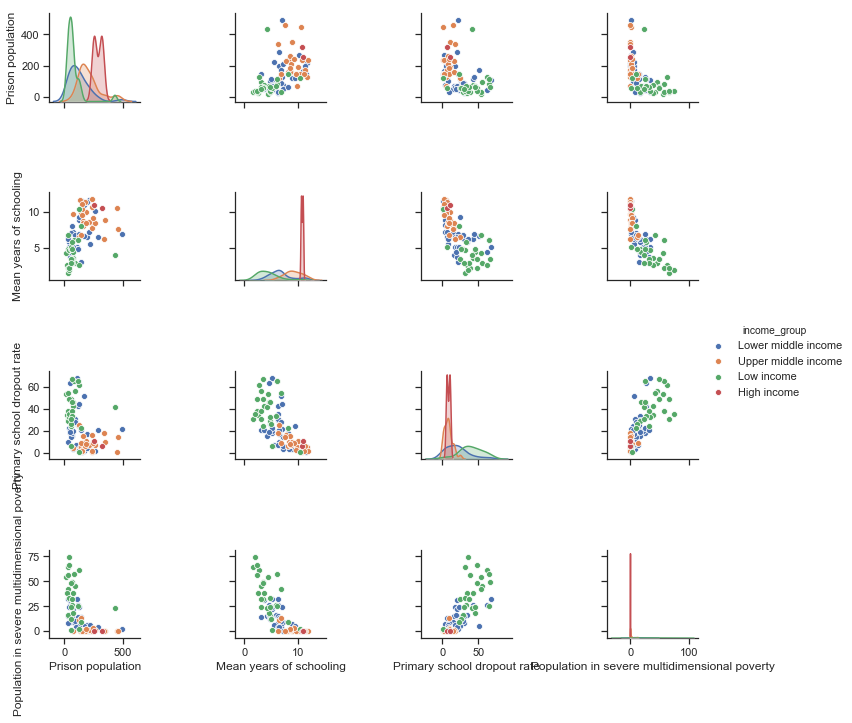

In [29]:
sns.set(style="ticks")
sns.pairplot(data_model4, hue='income_group')

### Evaluating Model 4 with Cross Validation

In [30]:
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics

predictors = ['Mean years of schooling', 'Primary school dropout rate',
           'Population in severe multidimensional poverty']

X = data_model4[predictors]
y = data_model4['Prison population']
N_FOLDS = 5

scores = cross_val_score(regr, X, y, cv = N_FOLDS)
predicted = cross_val_predict(regr, X, y, cv = N_FOLDS)
sklearn.metrics.r2_score(y, predicted) 

print ('Cross-validated scores:', scores)


Cross-validated scores: [ 0.36140827 -0.15865858  0.4406166   0.11444197  0.30399483]


=> Seguem sendo valores nao muito altos (< 0.5)

## Modelo 5 - Ridge Regression com as features do modelo 4 

In [33]:
# Dados que usaremos
data_model5 = data_model4


dfTrain, dfTest = train_test_split(data_model5, test_size=0.1, random_state = seed_value)

X_train = np.array(dfTrain[predictors])
y_train = np.array(dfTrain[prison])

X_test = np.array(dfTest[predictors])
y_test = np.array(dfTest[prison])

# Create linear regression object
regr = sk.linear_model.Ridge(normalize=True, alpha=0.8)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

print('Predictors:       ', predictors)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

Predictors:        ['Mean years of schooling', 'Primary school dropout rate', 'Population in severe multidimensional poverty']
Coefficients:      [[ 6.48231593 -0.3876342  -0.93378526]]
Intercept:         [113.13186207]
Mean squared error: 13907.39
Variance score:     -0.05


=> Diminui a variance score ao penalizar as features

## Modelo 6 - Lasso Regression com as features do modelo 4 

In [36]:
# Dados que usaremos
data_model6 = data_model4


dfTrain, dfTest = train_test_split(data_model6, test_size=0.1, random_state = seed_value)

X_train = np.array(dfTrain[predictors])
y_train = np.array(dfTrain[prison])

X_test = np.array(dfTest[predictors])
y_test = np.array(dfTest[prison])

# Create linear regression object
regr = sk.linear_model.Lasso(normalize=True)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

print('Predictors:       ', predictors)

# The coefficients
print('Coefficients:     ', regr.coef_)
print('Intercept:        ', regr.intercept_)

# The mean squared error (MSE)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score:     %.2f' % r2_score(y_test, y_pred))

Predictors:        ['Mean years of schooling', 'Primary school dropout rate', 'Population in severe multidimensional poverty']
Coefficients:      [ 8.11680422 -0.         -1.31419525]
Intercept:         [99.47056437]
Mean squared error: 13393.47
Variance score:     -0.01


# Lidando com dados reais (Abordagem 2)#
Percebemos que os dados, do jeito que foram agrupados não geram resultados satisfatórios de análise quando usamos a primeira abordagem acima. Vamos então trabalhar com outra abordagem agora para verificar se encontramos resultados melhores.

Obs: observando os nossos dados, percebemos que o indicador de prison population só tem dados na coluna 9999. Mas há indicadores de educação e/ou pobreza que possuem dados em mais de um ano e pode-se obervar que a coluna 9999 muitas vezes é apenas uma repetição do ano mais recente. Ou seja, Se nós pegarmos um indicador desses que tenha dados em mais de um ano e fizermos a média dele para usar nos modelos de regressão, vamos encontrar resultados diferentes...
Vamos checar se serão mais coerentes ou não!
